In [22]:
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np 
import pandas as pd 

import seaborn as sns 
import matplotlib.pyplot as plt 
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 
from sagemaker.predictor import csv_serializer   

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [30]:
!pip install xgboost

You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [31]:
import xgboost as xgb 

In [2]:
train_df = pd.read_csv('s3://cs623usaccidents/US_Accidents_Dec19.csv')
train_df.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,I-70 E,R,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,2584.0,Brice Rd,L,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,Accident on OH-32 State Route 32 Westbound at ...,NaN,State Route 32,R,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,I-75 S,R,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,NaN,Miamisburg Centerville Rd,R,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day


In [3]:
train_df.Source.unique()
states = train_df.State.unique()

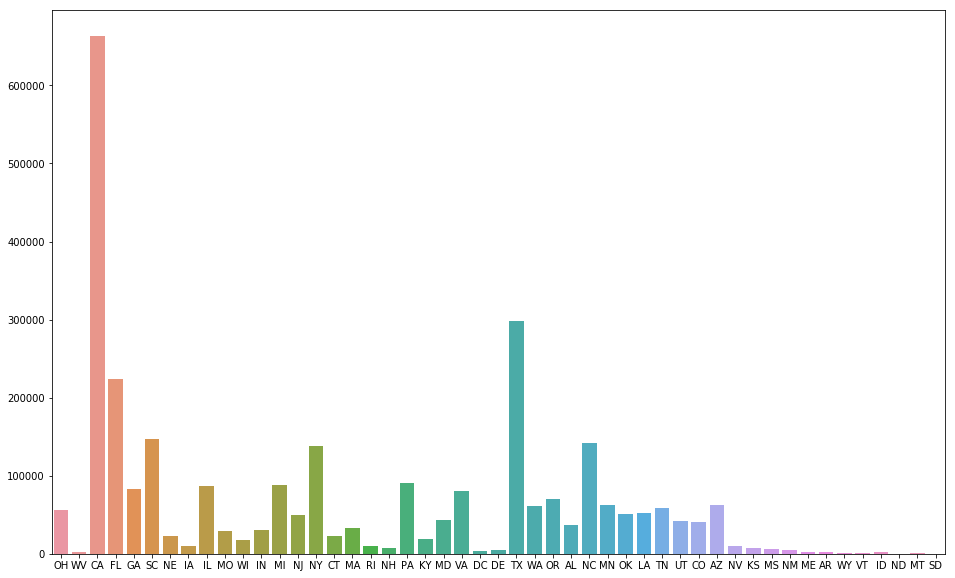

In [4]:
count_by_state=[]
for i in train_df.State.unique():
    count_by_state.append(train_df[train_df['State']==i].count()['ID'])

fig,ax = plt.subplots(figsize=(16,10))
sns.barplot(states,count_by_state)

In [5]:
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df

,Count,Column Type
0,ID,object
1,Source,object
2,TMC,float64
3,Severity,int64
4,Start_Time,object
5,End_Time,object
6,Start_Lat,float64
7,Start_Lng,float64
8,End_Lat,float64
9,End_Lng,float64


In [6]:
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,bool,13
1,int64,1
2,float64,14
3,object,21


In [7]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['columns_name','missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] /train_df.shape[0]
missing_df.loc[missing_df['missing_ratio']>0.777]

,columns_name,missing_count,missing_ratio


In [8]:
missin = missing_df.loc[missing_df['missing_count']>250000]
removelist = missin['columns_name'].tolist()
removelist

['TMC',
 'End_Lat',
 'End_Lng',
 'Number',
 'Wind_Chill(F)',
 'Wind_Speed(mph)',
 'Precipitation(in)']

In [9]:
train_df['Start_Time'] = pd.to_datetime(train_df['Start_Time'], errors='coerce')
train_df['End_Time'] = pd.to_datetime(train_df['End_Time'], errors='coerce')

# Extract year, month, day, hour and weekday
train_df['Year']=train_df['Start_Time'].dt.year
train_df['Month']=train_df['Start_Time'].dt.strftime('%b')
train_df['Day']=train_df['Start_Time'].dt.day
train_df['Hour']=train_df['Start_Time'].dt.hour
train_df['Weekday']=train_df['Start_Time'].dt.strftime('%a')

# Extract the amount of time in the unit of minutes for each accident, round to the nearest integer
td='Time_Duration(min)'
train_df[td]=round((train_df['End_Time']-train_df['Start_Time'])/np.timedelta64(1,'m'))

In [10]:
neg_outliers=train_df[td]<=0

# Set outliers to NAN
train_df[neg_outliers] = np.nan

# Drop rows with negative td
train_df.dropna(subset=[td],axis=0,inplace=True)

In [11]:
feature_lst=['Source','TMC','Severity','Start_Lng','Start_Lat','Distance(mi)','Side','City','County','State','Timezone','Temperature(F)','Humidity(%)','Pressure(in)', 'Visibility(mi)', 'Wind_Direction','Weather_Condition','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Turning_Loop','Sunrise_Sunset','Hour','Weekday', 'Time_Duration(min)']

In [12]:
df = train_df[feature_lst].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2974313 entries, 0 to 2974334
Data columns (total 34 columns):
Source                object
TMC                   float64
Severity              float64
Start_Lng             float64
Start_Lat             float64
Distance(mi)          float64
Side                  object
City                  object
County                object
State                 object
Timezone              object
Temperature(F)        float64
Humidity(%)           float64
Pressure(in)          float64
Visibility(mi)        float64
Wind_Direction        object
Weather_Condition     object
Amenity               float64
Bump                  float64
Crossing              float64
Give_Way              float64
Junction              float64
No_Exit               float64
Railway               float64
Roundabout            float64
Station               float64
Stop                  float64
Traffic_Calming       float64
Traffic_Signal        float64
Turning_Loop          flo

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


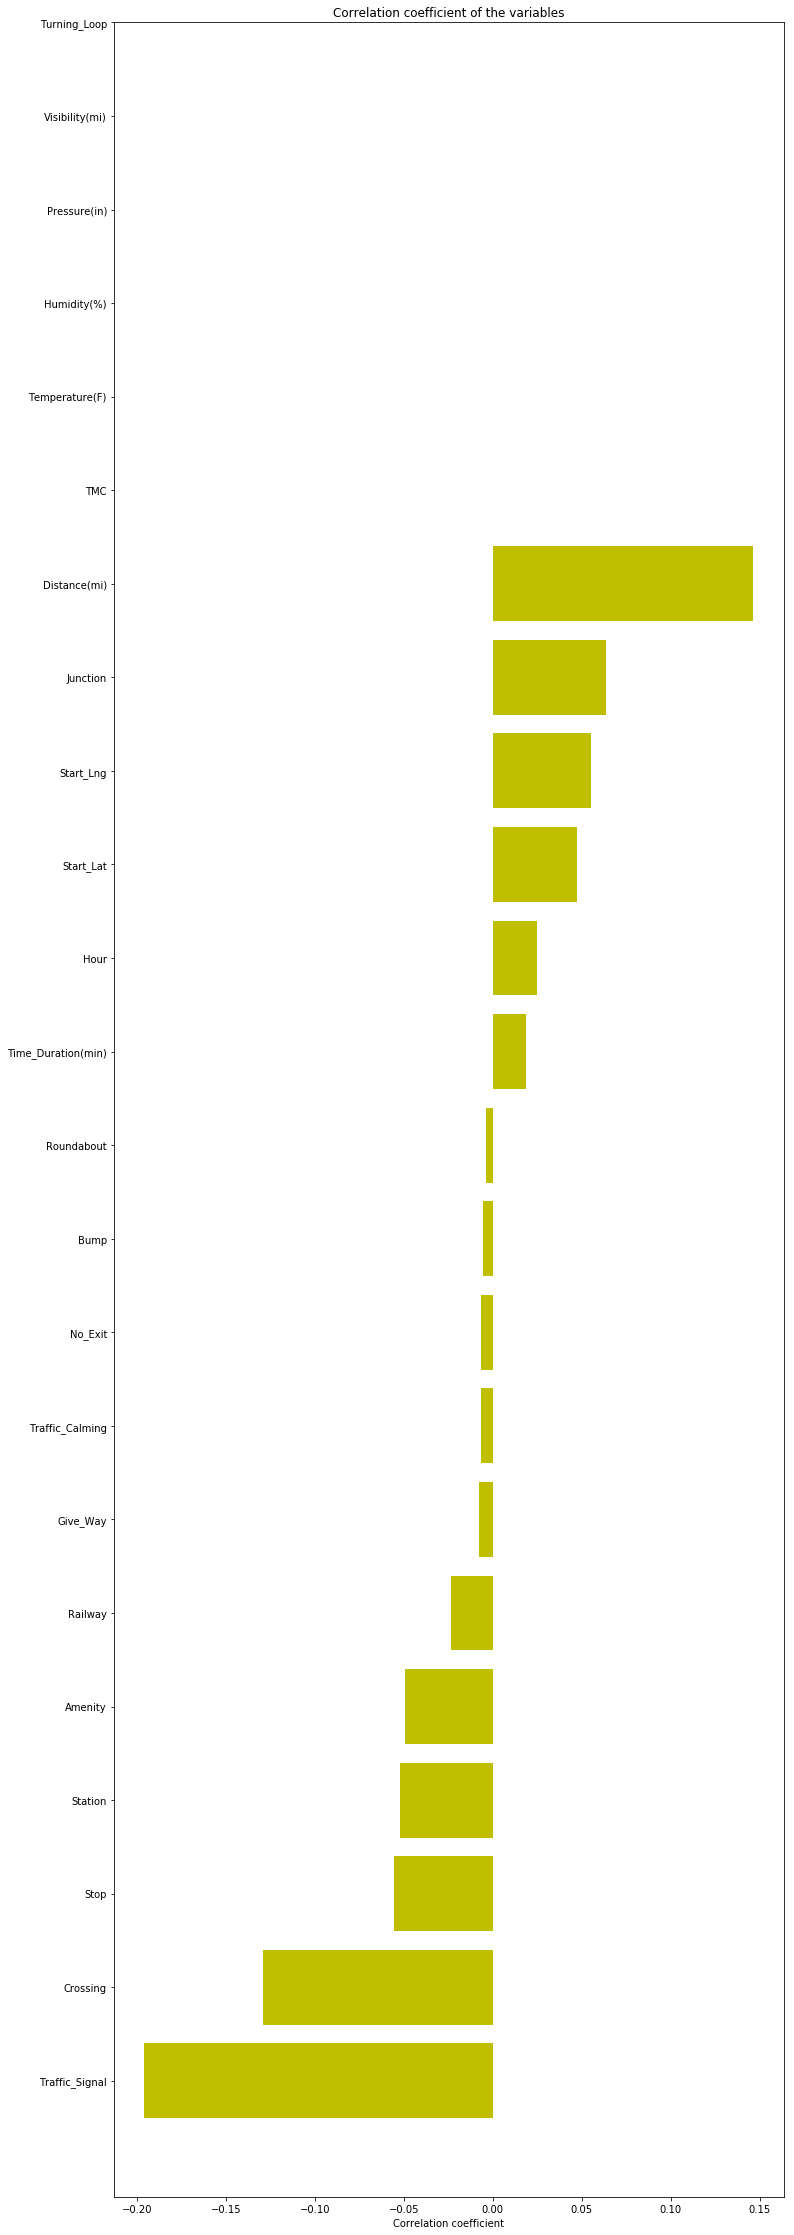

In [13]:
x_cols = [col for col in df.columns if col not in ['Severity'] if df[col].dtype=='float64']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(df[col].values, df.Severity.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')

ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
plt.show()

In [14]:
corr_zero_columns = ['Turning_Loop','Visibility(mi)','Pressure(in)','Humidity(%)','Temperature(F)','TMC']
for col in corr_zero_columns:
    print(col,len(df[col].unique()))

Turning_Loop 1
Visibility(mi) 82
Pressure(in) 995
Humidity(%) 101
Temperature(F) 828
TMC 22


In [15]:
corr_df_sel = corr_df.loc[(corr_df['corr_values']>0.05) | (corr_df['corr_values'] < -0.05)]
corr_df_sel

,col_labels,corr_values
19,Traffic_Signal,-0.195835
10,Crossing,-0.129030
17,Stop,-0.055393
16,Station,-0.052093
1,Start_Lng,0.055201
12,Junction,0.063437
3,Distance(mi),0.146395


In [16]:
df.dropna(subset=df.columns[df.isnull().mean()!=0], how='any', axis=0, inplace=True)
df.shape

(2181390, 34)

In [ ]:
train_y = df['Severity'].values
x_cols = [col for col in df.columns if col not in ['Severity'] if df[col].dtype=='float64']
train_col= df[x_cols]

fearture_name = train_col.columns.values 

from sklearn import ensemble 

model = ensemble.ExtraTreesRegressor(n_estimators=25, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0)
model.fit(train_col,train_y)

#plot imp 
importance = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],axis=0)
indices = np.argsort(importance)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importance[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), fearture_name[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

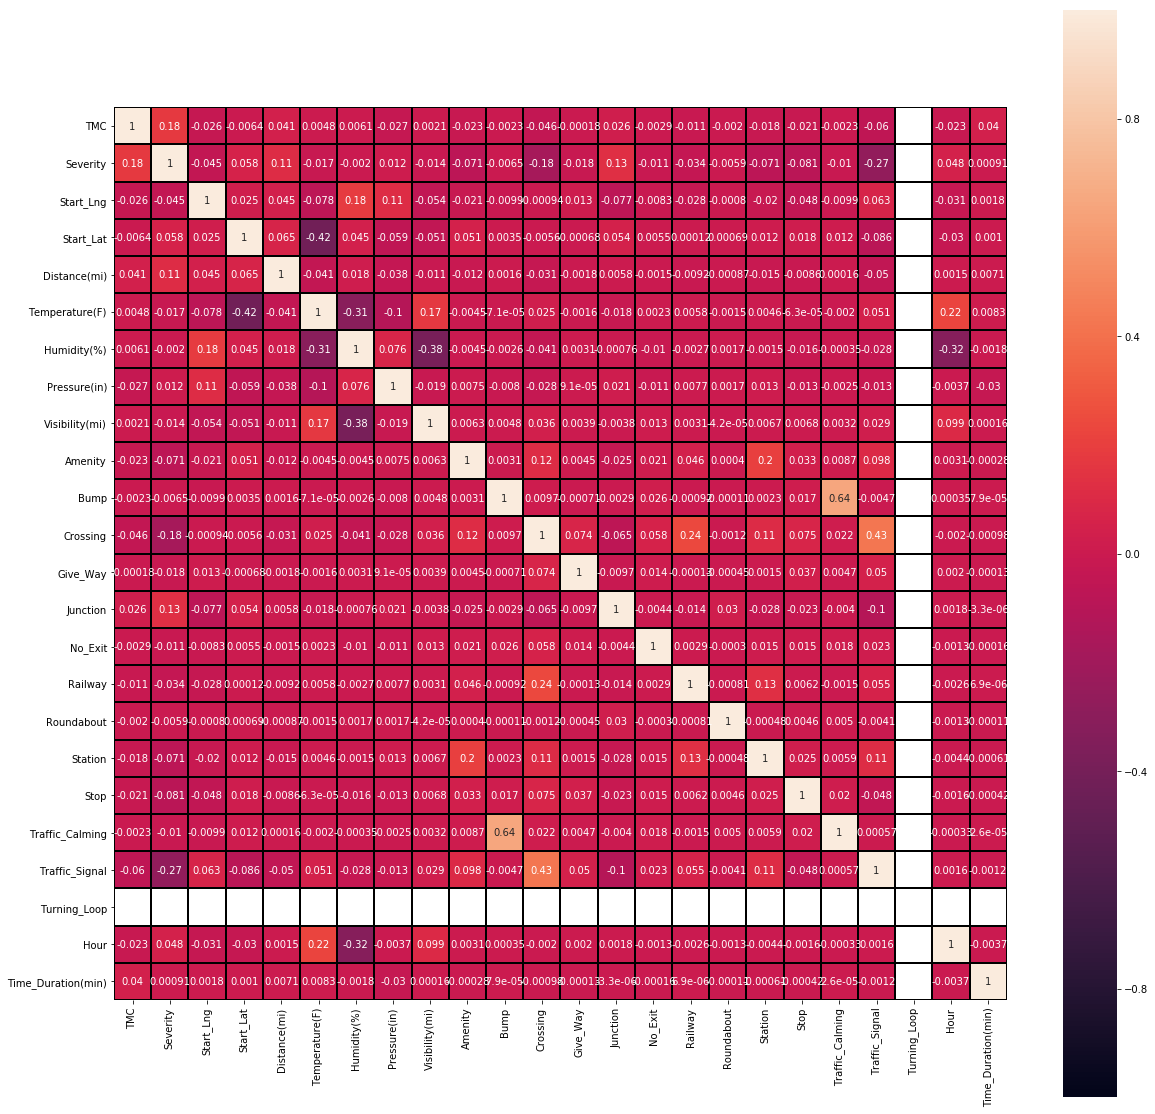

In [25]:
fig=plt.gcf()
fig.set_size_inches(20,20)
fig=sns.heatmap(df.corr(),annot=True,linewidths=1,linecolor='k',square=True,mask=False, vmin=-1, vmax=1,cbar_kws={"orientation": "vertical"},cbar=True)

In [26]:
train_data, test_data = np.split(train_df.sample(frac=1, random_state=1729), [int(0.7 * len(train_df))])
print(train_data.shape, test_data.shape)

(2082019, 55) (892294, 55)


In [32]:
sess = sagemaker.Session()


In [33]:
xgb_prames = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1,
    'seed' : 0
}



In [34]:
dtrain = xgb.DMatrix(train_col,train_y,feature_names=train_col.columns.values)

model = xgb.train(dict(xgb_prames, silent=0), dtrain, num_boost_round=50)

[21:46:51] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[21:46:52] WARNING: /workspace/src/learner.cc:328: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




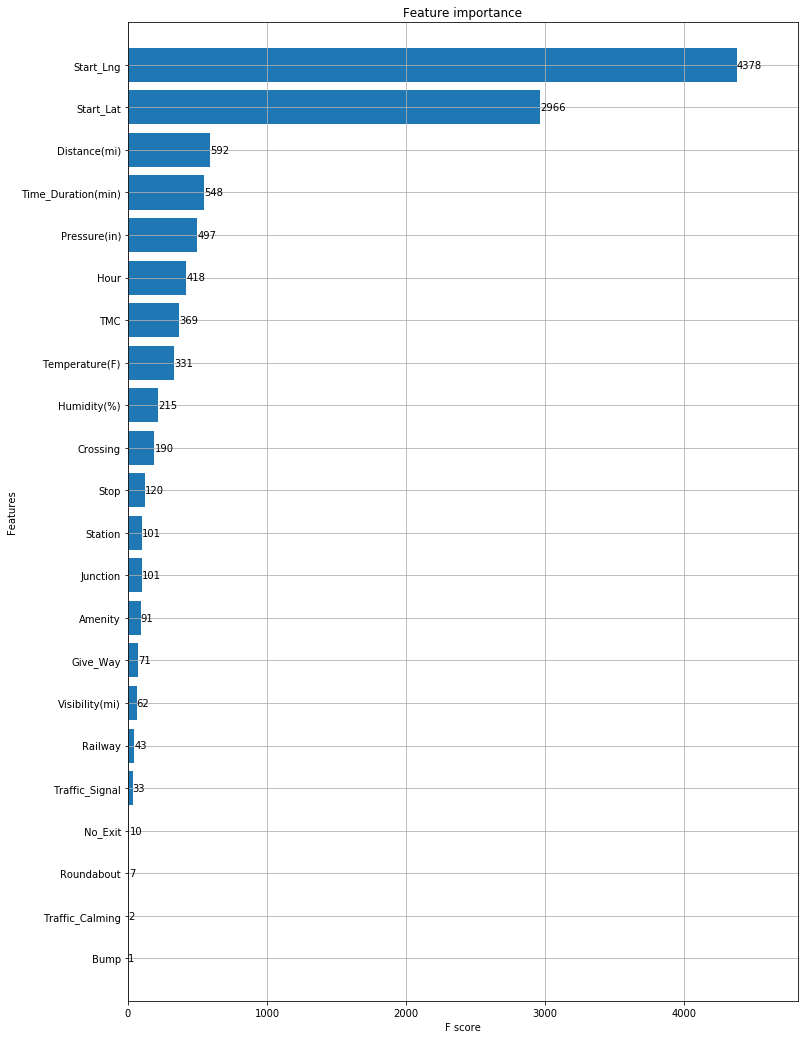

In [35]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [41]:
from sagemaker.predictor import csv_serializer
predictor = model.deploy(1, 'ml.m4.xlarge', serializer=csv_serializer)

AttributeError: module 'xgboost' has no attribute 'deploy'